In [235]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel
from ipywidgets import interact, fixed


def twoD_Gaussian((x,y), amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    """
    define 2D-Gaussian function and pass independant variables x and y as a list
    """
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    return offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))


def im_filter(signal,bkg,width,method='stdev'):


    #Generate noisy image of a square
#    im = np.zeros((128, 128))
#    im[32:-32, 32:-32] = 1

    # Generate noisy image of a Gaussian
#    im = Gaussian2DKernel(10,x_size=128,y_size=128).array
#    im = im/im.max()

    # Generate signal from full 2D-Gaussian
    # Create x and y indices
    x = np.linspace(0, 128, 129)
    y = np.linspace(0, 128, 129)
    x,y = np.meshgrid(x, y)
    #create signal image
    sigmaX = 5
    sigmaY = 10
    im = twoD_Gaussian((x, y), signal, 64, 64, sigmaX, sigmaY, 45, 0) + bkg   
        
    # adding noise    
    imn = np.random.poisson(im)
    #im = ndi.rotate(im, 15, mode='constant')
    #im = ndi.gaussian_filter(im, 4)
#    imn = im + noise * np.random.random(im.shape)

    f = np.fft.fft2(im)                  #do the fourier transform
    fshift = np.fft.fftshift(f)          #shift the zero to the center    

    f = np.fft.fft2(imn)                  #do the fourier transform
    fshift1 = np.fft.fftshift(f)          #shift the zero to the center

    if method == 'window': 
    #    Simple & Stupid filtering with a window around the central value. Set all the rest to zero
        filtdat = fshift1.copy() * 0
        xsize,ysize=fshift1.shape
        filtdat[xsize/2-width:xsize/2+width,ysize/2-width:ysize/2+width] = fshift1[xsize/2-width:xsize/2+width,ysize/2-width:ysize/2+width]

    if method == 'stdev':
        filtdat = fshift1.copy() 
        filtdat[np.abs(filtdat) < np.median(np.abs(filtdat))*width] = 0.0
        
    if method == 'gauss':
        filtdat = fshift1.copy() 
        filt = twoD_Gaussian((x, y), 1, int(filtdat.shape[0]/2.), int(filtdat.shape[1]/2.), width, width, 0, 0)
        filt[filt < 1e-6] = 0.  # truncates Gaussian wings
        filtdat = filtdat * filt

    f_ishift = np.fft.ifftshift(filtdat) 
    img_back2 = np.fft.ifft2(f_ishift) 
    img_back2 = np.abs(img_back2)

    
    fig, ( (ax1, ax2, ax3), (ax4,ax5, ax6) ) = plt.subplots(2, 3, figsize=(15,10))    

    cax1=ax1.imshow(im,interpolation='nearest')
    ax1.set_title('original image')
    plt.colorbar(cax1,ax=ax1,fraction=0.046, pad=0.03)
    
    cax2=ax2.imshow(imn,interpolation='nearest')
    ax2.set_title('original image + noise')
    plt.colorbar(cax2,ax=ax2,fraction=0.046, pad=0.03)

    cax3=ax3.imshow(img_back2,interpolation='nearest')
    ax3.set_title('filtered image')
    plt.colorbar(cax3,ax=ax3,fraction=0.046, pad=0.03)

    cax4=ax4.imshow(np.log10(abs(fshift)),interpolation='nearest' )
    ax4.set_title('FFT of original image')
    plt.colorbar(cax4,ax=ax4,fraction=0.046, pad=0.03)    
    
    cax5=ax5.imshow(np.log10(abs(fshift1)),interpolation='nearest' )
    ax5.set_title('FFT of noisy image')
    plt.colorbar(cax5,ax=ax5,fraction=0.046, pad=0.03)

    cax6=ax6.imshow(np.log10(abs(filtdat)),interpolation='nearest' )   
    ax6.set_title('filtered FFT')
    plt.colorbar(cax6,ax=ax6,fraction=0.046, pad=0.03)
    
    plt.show()

/Users/facero/Documents/Work/Program/Anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:97: RuntimeWarning: divide by zero encountered in log10


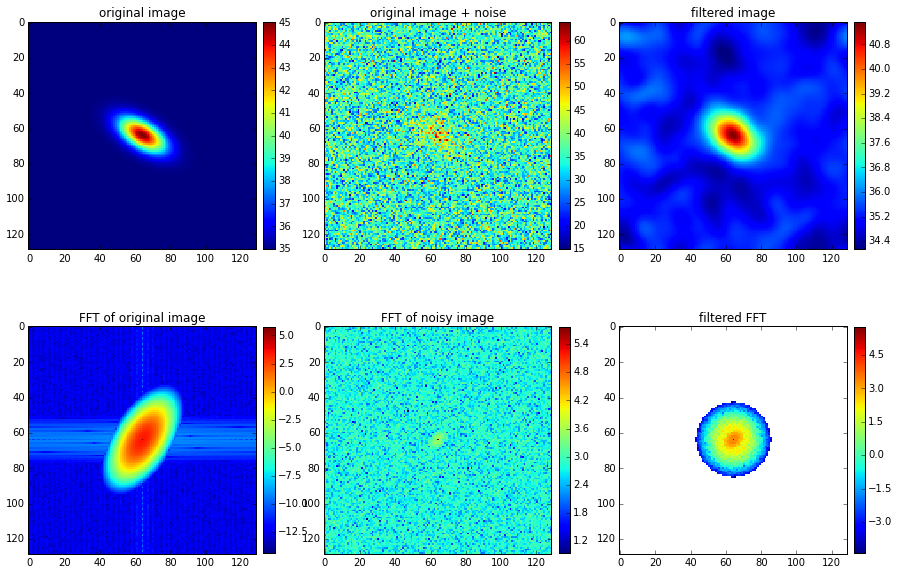

None

In [239]:
interact(im_filter,signal=fixed(10),bkg=(5,70,5),width=(0.5,5,0.5),method=('gauss','window','stdev'))

## TESTING ZONE

pieces of code below to test stuff


In [152]:



bkg = 5
size = 64
im = Gaussian2DKernel(10,x_size=size,y_size=size).array
im = im/im.max() * 10 + bkg
im = np.random.poisson(im)
width= 5

In [141]:
#%%timeit
f = np.fft.fft2(im)                  #do the fourier transform with rfft2 instead of fft2 
fshift1 = np.fft.fftshift(f)          #shift the zero to the center

#    Simple & Stupid filtering with a window around the central value. Set all the rest to zero
filtdat = fshift1.copy() * 0
xsize,ysize=fshift1.shape
filtdat[xsize/2-width:xsize/2+width,ysize/2-width:ysize/2+width] = fshift1[xsize/2-width:xsize/2+width,ysize/2-width:ysize/2+width]

f_ishift = np.fft.ifftshift(filtdat) 
img_back2 = np.fft.ifft2(f_ishift) 


In [127]:
filtdat = fshift1.copy() 
filtdat[filtdat < np.std(filtdat)*width] = 0.0

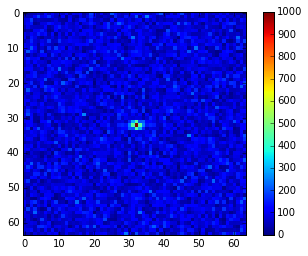

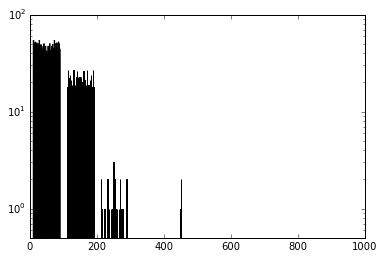

In [142]:
#np.std(filtdat)
plt.imshow(np.abs(fshift1),vmin=0,vmax=1000,interpolation='nearest')
plt.colorbar()
plt.show()
titi=plt.hist(np.abs(fshift1),range=(0,1000)) #, bins=256, range=(0.0, 1.0), fc='k', ec='k')
plt.yscale('log')
plt.ylim(0.5,100)
plt.show()

In [143]:
np.histogram(np.abs(fshift1),range=(0,1000))

(array([2850, 1197,   44,    0,    4,    0,    0,    0,    0,    0]),
 array([    0.,   100.,   200.,   300.,   400.,   500.,   600.,   700.,
          800.,   900.,  1000.]))

In [186]:
import scipy.signal



<function scipy.signal.signaltools.medfilt2d>

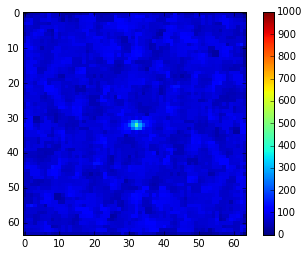

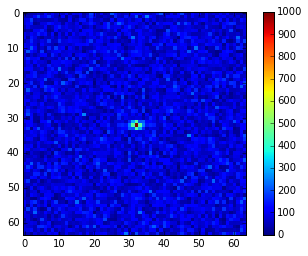

In [191]:
import scipy.signal
thres = np.std(np.abs(fshift1))*3
thres = 0
toto = scipy.signal.medfilt2d(np.abs(fshift1), kernel_size=3)
plt.imshow(toto,vmin=thres,vmax=1000,interpolation='nearest')
plt.colorbar()
plt.show()

plt.imshow(np.abs(fshift1),vmin=thres,vmax=1000,interpolation='nearest')
plt.colorbar()
plt.show()

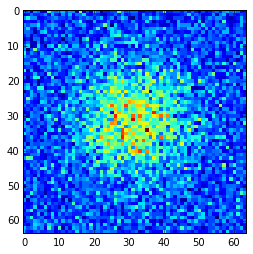

/Users/facero/Documents/Work/Program/Anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


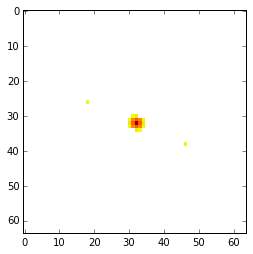

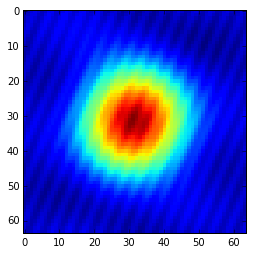

In [207]:
f = np.fft.fft2(im)                  #do the fourier transform with rfft2 instead of fft2 
fshift1 = np.fft.fftshift(f)          #shift the zero to the center

plt.imshow(im,interpolation='nearest') ; plt.show()
thres = 50
filtdat = fshift1.copy()

idx = np.where(np.abs(filtdat) < 500 ) ; filtdat[idx] = 0.0
#filtdat = scipy.signal.medfilt2d(np.abs(filtdat), kernel_size=1)


plt.imshow(np.log10(np.abs(filtdat)),vmin=0,interpolation='nearest')
plt.show()
f_ishift = np.fft.ifftshift(filtdat) 
img_back2 = np.fft.ifft2(f_ishift) 
plt.imshow(np.abs(img_back2),interpolation='nearest')
plt.show()

<matplotlib.colorbar.Colorbar instance at 0x115f7a5a8>

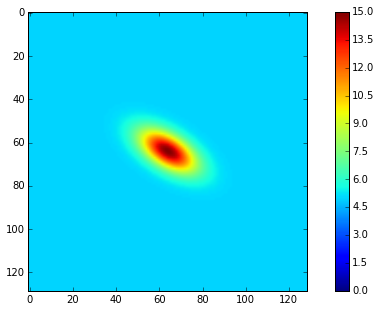

In [231]:
# Generate signal from full 2D-Gaussian
# Create x and y indices
x = np.linspace(0, 128, 129)
y = np.linspace(0, 128, 129)
x,y = np.meshgrid(x, y)
#create signal image
sigmaX = 5
sigmaY = 10
im = twoD_Gaussian((x, y), 10, 64, 64, sigmaX, sigmaY, 45, 0) + 5

fig, ax1 = plt.subplots(1, 1, figsize=(10,5))  

cax1=ax1.imshow(im,vmin=0)
plt.colorbar(cax1)


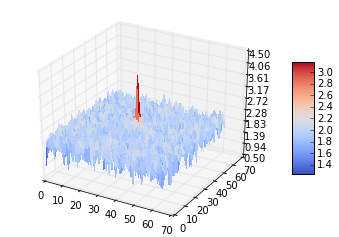

In [180]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')
x = np.linspace(0, 64, 64)
y = np.linspace(0, 64, 64)
X,Y = np.meshgrid(x, y)
Z = np.log10(np.abs(fshift1))
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#ax.set_zlim(-1.01, 1.01)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()